In [1]:
%load_ext autoreload
%autoreload 2
import sys
from numba import njit
from glob import glob
from natsort import natsorted
from joblib import Parallel, delayed
sys.path.insert(0, "../") 
import tifffile
from helpers import *

import global_params

In [2]:
def load_img_mask_pair(img_dir, mask_dir, normalise = False):
    suffix = img_dir.split(".")[-1]
    if "png" in suffix:
        img = np.array(Image.open(img_dir))
    elif "tif" in suffix:
        img = tifffile.imread(img_dir)
        if len(img.shape) == 3:
            img = img.sum(axis=0)
    if normalise:
        img = rescale_intensity(img, out_range=(0,1))
    mask = np.array(Image.open(mask_dir)) #Masks are always PNG
    return img, mask

@njit
def get_intensities(img, mask, mask_labels, img_2 = None):
    """
    Returns intensities of objects in the order provided by mask_labels
    """
    total_intensities = np.zeros(len(mask_labels))
    for l, mask_label in enumerate(mask_labels):
        idxs = np.where(mask == mask_label)
        if len(idxs[0]) > 100:
            pixel_intensities = np.zeros(len(idxs[0]))
            for k, (i, j) in enumerate(zip(idxs[0], idxs[1])):
                pixel_intensities[k] = img[i,j]
            total_intensity = np.sum(pixel_intensities)
            total_intensities[l] = total_intensity
    total_intensities_2 = np.zeros(len(mask_labels))

    if img_2 is not None:
        total_intensities_2 = np.zeros(len(mask_labels))
        for l, mask_label in enumerate(mask_labels):
            idxs = np.where(mask == mask_label)
            if len(idxs[0]) > 100:
                pixel_intensities = np.zeros(len(idxs[0]))
                for k, (i, j) in enumerate(zip(idxs[0], idxs[1])):
                    pixel_intensities[k] = img_2[i,j]
                total_intensity = np.sum(pixel_intensities)
                total_intensities_2[l] = total_intensity
    return total_intensities, total_intensities_2

def get_colony_diameter(mask):
    colony_regionprop = regionprops((mask > 0)*1)[0]
    return colony_regionprop.feret_diameter_max


def get_colony_centroid(mask):
    colony_regionprop = regionprops((mask > 0)*1)[0]
    #colony_centroid = colony_regionprop.centroid
    return colony_regionprop.centroid

def get_cell_pos(mask, mask_labels):
    cell_ys = np.zeros(len(mask_labels))
    cell_xs = np.zeros(len(mask_labels))
    for i, mask_label in enumerate(mask_labels):
        single_cell = (mask == mask_label) * 1
        cell_ys[i], cell_xs[i] = regionprops(single_cell)[0].centroid
    return cell_ys, cell_xs
#get_colony_size(mask)

def get_cell_n_neighbours(mask,mask_labels):
    radius = 5
    dilated = dilation(mask, skimage.morphology.disk(radius))
    rag = graph.RAG(dilated)
    rag.remove_node(0)

    n_neighbours = []
    for mask_label in mask_labels:
        n_neighbours.append(len(list(rag.neighbors(mask_label))))
    return n_neighbours

def get_cell_areas(mask, mask_labels):
    areas = np.zeros(len(mask_labels))
    for i, mask_label in enumerate(mask_labels):
        areas[i] = np.sum(mask == mask_label)
    return areas
    
#def get_dist_from_centre(mask, mask_labels):
#    dists = []
#    col_y, col_x = get_colony_centroid(mask)
#    print("Colony:", col_y, col_x)
#    for i, mask_label in enumerate(mask_labels):
#        single_cell = (mask == mask_label) * 1
#        cell_y, cell_x = regionprops(single_cell)[0].centroid
#        dist = np.sqrt( (cell_y - col_y)**2 + (cell_x - col_x)**2 )
#        print(f"Cell {mask_label}", cell_y, cell_x, dist)
#        #dists.append(dist)
#    return dists
#get_colony_size(mask)

In [3]:
wavelengths = [0.4,0.55,0.7]

In [4]:
PSFs = {}
NAs = list(reversed([1.49, 0.95]))
ns = list(reversed([1.518, 1.0]))
working_distances = list(reversed([170, 570]))
for wavelength in wavelengths:
    for NA, n, working_distance in zip(NAs, ns, working_distances):
        my_kernel = PSF_generator(
            radius = 150, 
            wavelength = 0.45, 
            NA=1.49, 
            n = 1.518, 
            resize_amount=1, 
            pix_mic_conv=global_params.pix_mic_conv, 
            apo_sigma = 10, 
            mode="3d fluo", 
            condenser="Ph3", 
            z_height = int(round(1/global_params.pix_mic_conv)),
            pz = 0.5, 
            working_distance=working_distance

        )
        my_kernel.calculate_PSF()
        psf = my_kernel.kernel.sum(axis=0)
        psf /= my_kernel.kernel.sum()
        PSFs[f"{wavelength}_{NA}_{n}_{working_distance}"] = psf

In [5]:
#raw_img_dir = "data/fluorescent_scenes/00010.png"
#synth_img_dir = "simulated_colonies/training_data_100x_0.5_green_1.49_1.518/synth_imgs/0009.tif"
#mask_dir = "simulated_colonies/training_data_100x_0.5_green_1.49_1.518/masks/0009.png"
#synth_img, mask = load_img_mask_pair(synth_img_dir, mask_dir, normalise=False)
#mask_labels = np.unique(mask)[1:]

#raw_img, _ = load_img_mask_pair(raw_img_dir, mask_dir, normalise=False)

#img_regionprops = regionprops(mask, intensity_image=img)
#synth_regionprops = regionprops(mask, intensity_image=rescaled_synth_img)
#plt.imshow(synth_img)
#plt.imshow(raw_img, cmap="Greys", alpha=0.4)

In [6]:
#raw_img_dirs = natsorted(glob("data/fluorescent_scenes/*"))
#synth_img_dirs = natsorted(glob("simulated_colonies/training_data_100x_0.45_blue_1.49_1.518/synth_imgs/*"))
#mask_dirs = natsorted(glob("data/masks/*"))

In [7]:
#for i, (raw_img_dir, synth_img_dir, mask_dir) in tqdm(enumerate(zip(raw_img_dirs, synth_img_dirs, mask_dirs))):
def load_and_calc_params(i, raw_img_dir, synth_img_dir, mask_dir, wavelength, NA, n, working_distance):
    raw_img, _ = load_img_mask_pair(raw_img_dir, mask_dir, normalise=False)
    synth_img, mask = load_img_mask_pair(synth_img_dir, mask_dir, normalise=False)
    mask_labels = np.unique(mask)[1:]

    pad_amount = 150
    deconv_img = restoration.wiener(np.pad(synth_img,pad_amount), PSFs[f"{wavelength}_{NA}_{n}_{working_distance}"], 10**-5, clip=False)[pad_amount:-pad_amount,pad_amount:-pad_amount]

    data = pd.DataFrame()

    data["Label"] = mask_labels
    data["True intensity"], data["Observed intensity"] = get_intensities(raw_img, mask, mask_labels, synth_img)
    _, data["Deconvolved intensity"] = get_intensities(raw_img, mask, mask_labels, deconv_img)

    data["Cell y"], data["Cell x"] = get_cell_pos(mask, mask_labels)
    data["Colony diameter"] = get_colony_diameter(mask)
    data["Colony centroid y"], data["Colony centroid x"] = get_colony_centroid(mask)
    data["N neighbours"] = get_cell_n_neighbours(mask, mask_labels)
    
    data["Colony N cells"] = len(mask_labels)
    data["Colony ID"] = i
    data["Wavelength"] = wavelength
    data["Area"] = get_cell_areas(mask, mask_labels)
    data["NA"] = NA
    data["ni"] = n
    return data

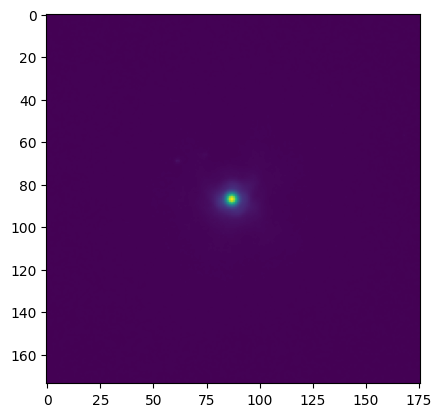

In [14]:
real_PSF = tifffile.imread("single_100x_PSF_postmag.tif").astype(np.float32)
c = int((real_PSF.shape[-1] - 200)/2)
x_offset = 2
y_offset = 3.5
real_PSF_slice = 44
real_PSF = real_PSF[real_PSF_slice-10:real_PSF_slice+10,2].sum(axis=0) # 0.05micron z step
real_PSF -= np.round(np.sort(real_PSF.flatten())[0:int(len(real_PSF.flatten())*.05)].mean()).astype(np.uint)
real_PSF = real_PSF[c-int(np.floor(y_offset)):-c-int(np.ceil(y_offset)),c-int(np.floor(x_offset)):-c+1-int(np.ceil(x_offset))]
real_PSF = rescale(real_PSF, (0.0655/1.5) / global_params.pix_mic_conv  , anti_aliasing=True)
real_PSF = real_PSF/real_PSF.sum()
plt.imshow(real_PSF)

In [17]:
#for i, (raw_img_dir, synth_img_dir, mask_dir) in tqdm(enumerate(zip(raw_img_dirs, synth_img_dirs, mask_dirs))):
def load_and_calc_params_empirical_PSF(i, raw_img_dir, synth_img_dir, mask_dir, wavelength, NA, n, working_distance):
    raw_img, _ = load_img_mask_pair(raw_img_dir, mask_dir, normalise=False)
    synth_img, mask = load_img_mask_pair(synth_img_dir, mask_dir, normalise=False)
    mask_labels = np.unique(mask)[1:]

    pad_amount = 150
    deconv_img = restoration.wiener(np.pad(synth_img,pad_amount), real_PSF, 10**-5, clip=False)[pad_amount:-pad_amount,pad_amount:-pad_amount]

    data = pd.DataFrame()

    data["Label"] = mask_labels
    data["True intensity"], data["Observed intensity"] = get_intensities(raw_img, mask, mask_labels, synth_img)
    _, data["Deconvolved intensity"] = get_intensities(raw_img, mask, mask_labels, deconv_img)

    data["Cell y"], data["Cell x"] = get_cell_pos(mask, mask_labels)
    data["Colony diameter"] = get_colony_diameter(mask)
    data["Colony centroid y"], data["Colony centroid x"] = get_colony_centroid(mask)
    data["N neighbours"] = get_cell_n_neighbours(mask, mask_labels)
    
    data["Colony N cells"] = len(mask_labels)
    data["Colony ID"] = i
    data["Wavelength"] = wavelength
    data["Area"] = get_cell_areas(mask, mask_labels)
    data["NA"] = NA
    data["ni"] = n
    return data

In [18]:
data = []

raw_img_dirs = natsorted(glob("data/fluorescent_scenes/*"))
synth_img_dirs = natsorted(glob(f"simulated_colonies_empirical_PSF_corrected//training_data_100x_0.55_green_1.49_1.518/synth_imgs/*"))
#assert len(synth_img_dirs) == len(raw_img_dirs)
mask_dirs = natsorted(glob("data/masks/*"))
data_ = Parallel(n_jobs=-1)(delayed(load_and_calc_params_empirical_PSF)(i, raw_img_dir, synth_img_dir, mask_dir, 0.55, 1.49, 1.518, 170) for i, (raw_img_dir, synth_img_dir, mask_dir) in  tqdm(enumerate(zip(raw_img_dirs, synth_img_dirs, mask_dirs)), total=len(mask_dirs)))
data_ = pd.concat(data_)
data_["NA"] = "Empirical 1.49"
data.append(data_)

  0%|          | 0/3476 [00:00<?, ?it/s]

In [20]:
def bin_data(bins, column, df, new_column_name):
    return pd.cut(df[column], bins=bins, labels=[i for i in sorted([x.mid  for x in pd.cut(df[column], bins=bins).unique()]) ])

def bin_data_mid(bins, column, df, new_column_name):
    return pd.cut(df[column], bins=bins, labels=[i for i in sorted([x.mid  for x in pd.cut(df[column], bins=bins).unique()]) ])


def bin_data_range(bins, column, df, new_column_name):
    return pd.cut(df[column], bins=bins, labels=[i for i in ([f"[{int(x.left+1)}, {int(x.right+1)})"  for x in pd.cut(df[column], bins=bins).unique()]) ])


data = data_
data["Distance from centre of colony"] = np.sqrt(
    (data["Cell y"] - data["Colony centroid y"])**2 + (data["Cell x"] - data["Colony centroid x"])**2 
)
data["Normalised distance from centre of colony"] = data["Distance from centre of colony"] / (data["Colony diameter"]/2)
data["Mean true intensity"] = data["True intensity"] / data["Area"]
data["Mean observed intensity"] = data["Observed intensity"] / data["Area"]
data["Mean deconvolved intensity"] = data["Deconvolved intensity"] / data["Area"]
colony_groupby = data.groupby(["Wavelength", "Colony ID", "Colony N cells", "NA", "ni"])[["Mean true intensity", "Mean observed intensity", "Mean deconvolved intensity"]]
CVs = colony_groupby.std() / colony_groupby.mean()
CVs.columns = ["True CV", "Observed CV", "Deconvolved CV"]
CVs = CVs.reset_index()
data = pd.merge(data, CVs, on=["Colony ID", "Wavelength", "Colony N cells", "NA"])
data["Observed var"] = (data["Mean observed intensity"] * data["Observed CV"]) **2 
data["Observed cell intensity / True cell intensity (mean)"] = data["Mean observed intensity"] / data["Mean true intensity"]
data["Colony N cells (binned)"] = bin_data_range(bins = 3, df=data, column="Colony N cells", new_column_name="Colony N cells (binned)")
data["Normalised distance from centre of colony (binned)"] = bin_data(bins=10, df = data, column = "Normalised distance from centre of colony", new_column_name=None)
data["Colony N cells (fine-binned)"] = bin_data(bins = 15, df=data, column="Colony N cells", new_column_name="Colony N cells (fine-binned)")


data["Colony size"] = "Not assigned"
data.loc[data.eval("`Colony N cells` < 10"), "Colony size"] = "Small (<10 cells)"
data.loc[data.eval("`Colony N cells` > 200"), "Colony size"] = "Large (>200 cells)"


In [9]:
for wavelength in wavelengths:
    for NA, n, working_distance in zip(NAs, ns, working_distances):
        raw_img_dirs = natsorted(glob("data/fluorescent_scenes/*"))
        synth_img_dirs = natsorted(glob(f"simulated_colonies_normal/training_data_100x_{wavelength}_*_{NA}_{n}/synth_imgs/*"))
        #assert len(synth_img_dirs) == len(raw_img_dirs)
        mask_dirs = natsorted(glob("data/masks/*"))
        data_ = Parallel(n_jobs=-1)(delayed(load_and_calc_params)(i, raw_img_dir, synth_img_dir, mask_dir, wavelength, NA, n, working_distance) for i, (raw_img_dir, synth_img_dir, mask_dir) in  tqdm(enumerate(zip(raw_img_dirs, synth_img_dirs, mask_dirs)), total=len(mask_dirs)))
        data.extend(data_)

  0%|          | 0/3476 [00:00<?, ?it/s]

/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor.

  0%|          | 0/3476 [00:00<?, ?it/s]

/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor.

  0%|          | 0/3476 [00:00<?, ?it/s]

/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


  0%|          | 0/3476 [00:00<?, ?it/s]

/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor.

  0%|          | 0/3476 [00:00<?, ?it/s]

/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor.

  0%|          | 0/3476 [00:00<?, ?it/s]

/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [10]:
data = pd.concat(data)

In [11]:
data.to_pickle("cell_data.pickle")